In [1]:
# imports
from __future__ import annotations

import concurrent.futures
import datetime
import logging
import pathlib as pl
import random
import shutil
import string
import time
from math import pi
from typing import Any

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
from rich.console import Console
from rich.table import Table
from rl.actor_critic import GAE, Actor, ActorCritic, Critic
from rl.network import GINPolicyNetwork, GINValueNetwork
from rl.utils import Sampler, to_graph
from torch.optim.adam import Adam
from torch.utils.tensorboard.writer import SummaryWriter

from mcerl.env import Env
from mcerl.utils import (
    delta_time_reward_standardize,
    exploration_reward_rescale,
    reward_sum,
)

%matplotlib inline

In [2]:
# load map
maps = []
easy_maps = [
    "map/easy/12.png",
    "map/easy/95.png",
    "map/easy/83.png",
    "map/easy/69.png",
    "map/easy/50.png",
]
hard_maps = ["map/hard/53.png", "map/40.png"]
medium_maps = ["map/medium/12.png", "map/40.png", "map/medium/11.png"]

map_height, map_width = 300, 200

for map_img in easy_maps + hard_maps + medium_maps:
    img = Image.open(map_img)
    img = ImageOps.grayscale(img)
    img = img.resize((map_width, map_height))
    grid_map = np.array(img)
    grid_map[grid_map < 100] = 0
    grid_map[grid_map >= 100] = 255
    maps.append(grid_map)

In [ ]:
plt.imshow(maps[-4], cmap="gray", vmin=0, vmax=255)

In [ ]:
# define parameters
#########################
# log参数
#########################

# workspace
workspace_dir = pl.Path.cwd()
# output
output_dir = pl.Path(workspace_dir) / "output"
current_date = datetime.datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
random_string = "".join(random.choices(string.ascii_letters + string.digits, k=6))
session_name = f"EVAL_{current_date}_{random_string}"
# experiment
experiment_dir = output_dir / session_name
log_dir = experiment_dir / "log"
cpp_env_log_path = log_dir / "env.log"
py_env_log_path = log_dir / "env_py.log"
model_dir = experiment_dir / "model"
output_images_dir = experiment_dir / "images"
tensorboard_dir = experiment_dir / "tensorboard"

experiment_dir.mkdir(parents=True, exist_ok=True)
log_dir.mkdir(parents=True, exist_ok=True)
model_dir.mkdir(parents=True, exist_ok=True)
output_images_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir.mkdir(parents=True, exist_ok=True)


# logger
log_level = "warning"
cpp_env_log_level = "trace"
py_env_log_level = "debug"
logger = logging.getLogger()
logger.setLevel(py_env_log_level.upper())
for handler in logger.handlers:
    logger.removeHandler(handler)
logger.addHandler(logging.FileHandler(py_env_log_path, mode="w"))

#########################
# 环境参数
#########################


exclude_parameters = list(locals().keys())

# 几个agent
num_agents = 3

# agent的初始位置
agent_poses = None

# agent的初始方向
num_rays = 16

# 一个env最多迭代多少步
max_steps = 100000

# 一个agent最多迭代多少步
max_steps_per_agent = 100

# 传感器的范围
ray_range = 30

# 速度(pixel per step)
velocity = 1

# 最小的frontier pixel数
min_frontier_size = 10

# 最大的frontier pixel数
max_frontier_size = 30

# 探索的阈值
exploration_threshold = 0.95


# 一个frontier最多可以获得多少信息增益
max_exploration_gain = ray_range**2 * pi / 2.0


#########################
# PPO参数
#########################

# gae权重
lmbda = 0.97

# discount factor
gamma = 0.96

# reward scale
# 0.5*tanh((x-average_val)/stddev_val)+0.5
average_val = 852
stddev_val = 765
# 1/(1+((x-x_star)/sigma)^(2*b))
b = 1
x_star = 10
sigma = 40

# clip范围
clip_coefficient = 0.15

# 最大gradient范数
max_grad_norm = 0.5

# ESS
entropy_weight = 0.005

# policy loss的权重
policy_loss_weight = 1.0

# value loss的权重
value_loss_weight = 0.5

# learning rate
lr = 5e-4
#########################
# 训练参数
#########################

# 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 总共训练的次数
n_iters = 1000

# 每次训练的frame数(大约)
n_frames_per_iter = 5000

# 每次训练的并行环境数(num worker)
n_parallel_envs = 31

# 每次训练的epoch数, 即数据要被训练多少次
n_epochs_per_iter = 5

# 每次epoch的mini_batch大小
n_frames_per_mini_batch = 500

# 每个agent的最大步数
max_steps_per_agent = 40

# 每次训练所用到的总的环境数量
# n_envs = round(n_frames_per_iter / num_agents / max_steps_per_agent)

n_envs = 76

# 每个epoch的frame数
n_frames_per_epoch = n_frames_per_iter

# 每个epoch的mini_batch数
n_mini_batches_per_epoch = n_frames_per_epoch // n_frames_per_mini_batch


parameters = {k: v for k, v in locals().items() if k not in [*exclude_parameters, "exclude_parameters"]}
console = Console()
console.print(parameters)

In [5]:
# transform function
# env_transform
def env_transform(frame_data: dict[str, Any]) -> dict[str, Any]:
    """
    normalize position, exploration gain,etc.
    Note that we need to check if env is done
    """

    width = float(map_width)
    height = float(map_height)

    # normalize frontier position to [0,1] and exploration gain to [0,1]
    frame_data["observation"]["frontier_points"] = [
        (
            float(x) / width,
            float(y) / height,
            float(gain) / max_exploration_gain,
            np.tanh(float(distance) / float(ray_range)),
        )
        for x, y, gain, distance in frame_data["observation"]["frontier_points"]
    ]

    # normalize position to [0,1]
    frame_data["observation"]["pos"] = [
        (float(x) / width, float(y) / height)
        for x, y in frame_data["observation"]["pos"]
    ]

    frame_data["observation"]["target_pos"] = [
        (float(x) / width, float(y) / height)
        for x, y in frame_data["observation"]["target_pos"]
    ]

    # build graph
    frame_data = to_graph(frame_data)

    return frame_data  # noqa: RET504 explicit return


# policy transform
def device_cast(
    frame_data: dict[str, Any], device: torch.device | None = None
) -> dict[str, Any]:
    """
    cast data to device
    """
    device = torch.device("cuda") if device is None else device
    if "graph" in frame_data["observation"]:
        frame_data["observation"]["graph"] = frame_data["observation"]["graph"].to(
            device
        )

    return frame_data

In [6]:
# define policy

policy_network = GINPolicyNetwork(dim_feature=6, dim_h=32)
value_network = GINValueNetwork(dim_feature=6, dim_h=32)
actor = Actor(policy_network=policy_network)
critic = Critic(value_network=value_network)
wrapped_actor_critic = ActorCritic(actor=actor, critic=critic, forward_preprocess=device_cast)
wrapped_actor_critic = wrapped_actor_critic.to(device)
value_estimator = GAE(gamma=gamma, lmbda=lmbda)
optimizer = Adam(wrapped_actor_critic.parameters(), lr=lr)

In [7]:
def greedy_policy(frame_data: dict[str, Any],**kwargs) -> dict[str, Any]:
    """
    greedy policy
    """
    pos = frame_data["observation"]["pos"][:2]
    distances = [
        np.linalg.norm(np.array(pos) - np.array(frontier[:2]))
        for frontier in frame_data["observation"]["frontier_points"]
    ]
    frame_data['action']=torch.tensor(np.argmin(distances))
    return frame_data


In [ ]:
# load state dict
wrapped_actor_critic.load_state_dict(torch.load("output/best/800_steps_32_depth_with_batch_norm.pt"))

In [ ]:
# parameters for env rollout

rollout_parameters = {
    "policy": greedy_policy,
    "env_transform": env_transform,
    "agent_poses": agent_poses,
    "num_agents": num_agents,
    "max_steps": max_steps,
    "max_steps_per_agent": max_steps_per_agent,
    "velocity": velocity,
    "sensor_range": ray_range,
    "num_rays": num_rays,
    "min_frontier_pixel": min_frontier_size,
    "max_frontier_pixel": max_frontier_size,
    "exploration_threshold": exploration_threshold,
    "return_maps": True,
    "requires_grad": False,
    "check_validation": True,
}
console.print(rollout_parameters)

In [ ]:
# eval:

env = Env(
    cpp_env_log_level,
    cpp_env_log_path.as_posix(),
)
rollout_parameters["grid_map"] = maps[-4]
rollouts = []
min_rollout=None
for i in range(30):
    with torch.no_grad():
        _, eval_data = env.eval(**rollout_parameters)
        if min_rollout is None or eval_data[-1]["tick"]<min_rollout[-1]["tick"]:
            min_rollout=eval_data
        rollouts.append(eval_data)
    print(f"rollout {i} done,tick:{eval_data[-1]['tick']}")

In [11]:
data_to_process=rollouts[13]

In [ ]:
ticks = set([data["tick"] for data in data_to_process])
ticks = sorted(list(ticks))
tick_data = {tick: [] for tick in ticks}
for data in data_to_process:
    tick = data["tick"]
    tick_data[tick].append(
        {
            "id": data["agent_id"],
            "pos": data["agent_pos"],
            "target_pos": data["agent_target"],
            "path": data["agent_path"],
            "global_map": data["global_map"],
        }
    )
images = []
import tqdm

for tick, data in tqdm.tqdm(tick_data.items()):
    fig, ax = plt.subplots()
    ax.imshow(data[-1]["global_map"], cmap="gray", vmin=0, vmax=255)
    for agent_data in data:
        pos = agent_data["pos"]
        ax.plot(pos[0], pos[1], "ro")
        target_pos = agent_data["target_pos"]
        ax.plot(target_pos[0], target_pos[1], "go")
        path = agent_data["path"]
        if len(path) == 0:
            continue
        path = np.array(path)
        ax.plot(path[..., 0], path[..., 1], "r-")
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    image = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3).copy()
    images.append(image)
    plt.close(fig)

In [ ]:
from moviepy.editor import ImageSequenceClip
import numpy as np

# Generate a sequence of frames
clip = ImageSequenceClip(images, fps=120.0,)
clip.write_videofile("greedy2output1290.mp4",fps=120.0)

In [8]:
# single rollout
# env = Env(
#     log_level,
#     cpp_env_log_path.as_posix(),
# )
# rollout_parameters["grid_map"] = random.choice(maps)
# with torch.no_grad():
#     single_rollouts = env.rollout(**rollout_parameters)
# rollouts = single_rollouts

In [ ]:
# parallel rollout


def rollout_env(env, params):
    """在给定的环境中执行rollout。"""
    random_map = random.choice(maps)
    params["grid_map"] = random_map
    return env.rollout(**params)


def parallel_rollout(envs, num_parallel_envs, rollout_params):
    """
    在多个仿真环境中并行执行rollout。

    :param envs: List[object] - 仿真环境列表, 每个环境对象应有一个rollout方法。
    :param num_parallel_envs: int - 最大并行环境数量。
    :param rollout_params: dict - 传递给每个环境rollout方法的参数。
    :return: List - 每个环境的rollout结果列表。
    """
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_parallel_envs) as executor:
        # 提交所有环境的rollout任务
        futures = {executor.submit(rollout_env, env, rollout_params): env for env in envs}

        # 收集所有任务的结果
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                results.extend(result)
            except Exception as e:
                print(f"环境 {futures[future]} 的rollout执行时发生错误: {e}")

    return results


envs = [Env(cpp_env_log_level, cpp_env_log_path=cpp_env_log_path.as_posix()) for i in range(n_envs)]
len(envs)

In [10]:
# rollouts = []
# for i in range(15):
#     current_envs = 31 + i * 5
#     envs = [Env(cpp_env_log_level, cpp_env_log_path=cpp_env_log_path.as_posix()) for _ in range(current_envs)]
#     average_time = []
#     for j in range(4):
#         start_time = time.time()
#         with torch.no_grad():
#             parallel_rollout(
#                 envs=envs,
#                 num_parallel_envs=n_parallel_envs,
#                 rollout_params=rollout_parameters,
#             )
#         end_time = time.time()
#         average_time.append(end_time - start_time)
#     print(f"第 {i+1} 次并行rollout,一共 {current_envs} 个环境, 耗时 {np.mean(average_time)} 秒")

In [11]:
# for logging
writer = SummaryWriter(tensorboard_dir / "ppo")
writer.add_text("parameters", str(parameters))

In [ ]:
# train loop

console_logging_data = {}
start_time = time.time()
for _n_iter in range(n_iters):
    # collect data
    iter_start_time = time.time()
    data_collection_start_time = time.time()
    with torch.no_grad():
        env_rollout_start_time = time.time()
        rollouts = parallel_rollout(
            envs=envs,
            num_parallel_envs=n_parallel_envs,
            rollout_params=rollout_parameters,
        )
        env_rollout_time = time.time() - env_rollout_start_time

        data_post_process_start_time = time.time()
        # normalize rewards
        rollouts = [exploration_reward_rescale(rollout, a=average_val, b=stddev_val) for rollout in rollouts]
        rollouts = [delta_time_reward_standardize(rollout, b=b, sigma=sigma, x_star=x_star) for rollout in rollouts]

        rollouts = [reward_sum(rollout, gamma=gamma) for rollout in rollouts]
        data_post_process_time = time.time() - data_post_process_start_time

        gae_start_time = time.time()
        # compute GAE
        rollouts = [value_estimator(rollout) for rollout in rollouts]
        flattened_rollouts = [frame_data for rollout in rollouts for frame_data in rollout]
        exploration_rewards = np.mean(
            [frame_data["next"]["reward"]["exploration_reward"] for frame_data in flattened_rollouts]
        )
        time_step_rewards = np.mean(
            [frame_data["next"]["reward"]["time_step_reward"] for frame_data in flattened_rollouts]
        )
        total_rewards = np.mean([frame_data["next"]["reward"]["total_reward"] for frame_data in flattened_rollouts])
        actual_frames_per_iter = len(flattened_rollouts)
        gae_time = time.time() - gae_start_time
        # add to sampler
        data_flatten_start_time = time.time()

        graphs = []
        rewards = []
        values = []
        advantages = []
        log_probs = []
        returns = []
        total_times = []

        for frame_data in flattened_rollouts:
            graphs.append(frame_data["observation"]["graph"])
            rewards.append(frame_data["next"]["reward"]["total_reward"])
            values.append(frame_data["value"])
            advantages.append(frame_data["advantage"])
            log_probs.append(frame_data["log_prob"])
            returns.append(frame_data["return"])
            total_times.append(frame_data["info"]["total_time_step"])
        rewards = torch.tensor(rewards).to(device)
        values = torch.tensor(values).to(device)
        advantages = torch.tensor(advantages).to(device)
        log_probs = torch.tensor(log_probs).to(device)
        returns = torch.tensor(returns).to(device)
        total_times = torch.tensor(total_times).to(device)

        sampler = Sampler(
            batch_size=n_frames_per_mini_batch,
            length=len(flattened_rollouts),
            graphs=graphs,
            rewards=rewards,
            values=values,
            advantages=advantages,
            log_probs=log_probs,
            returns=returns,
            total_times=total_times,
        )
        data_flatten_time = time.time() - data_flatten_start_time
    data_collection_time = time.time() - data_collection_start_time

    training_start_time = time.time()
    clip_fraction = []
    for _n_epoch in range(n_epochs_per_iter):
        epoch_start_time = time.time()
        n_mini_batches_per_epoch = actual_frames_per_iter // n_frames_per_mini_batch
        for _n_mini_batch in range(n_mini_batches_per_epoch):
            mini_batch_start_time = time.time()

            sample_start_time = time.time()
            # sample data
            mini_batch_data = sampler.random_sample()
            graphs = mini_batch_data["graphs"].to(device)
            rewards = mini_batch_data["rewards"]
            values = mini_batch_data["values"].to(device).flatten()
            advantages = mini_batch_data["advantages"].to(device).flatten()
            prev_log_prob = mini_batch_data["log_probs"].to(device).flatten()
            returns = mini_batch_data["returns"].to(device).flatten()
            total_times = mini_batch_data["total_times"]
            frame_indices = mini_batch_data["frame_indices"].to(device)
            sample_time = time.time() - sample_start_time

            training_data_prepare_start_time = time.time()
            # get minibatch data and transform to tensor for training

            forward_start_time = time.time()
            new_action, new_log_probs, new_values, entropy = wrapped_actor_critic.forward_parallel(
                graphs, frame_indices
            )
            new_log_probs = new_log_probs.to(device).flatten()
            new_values = new_values.to(device).flatten()
            forward_time = time.time() - forward_start_time

            data_prepare_time = time.time() - training_data_prepare_start_time

            loss_compute_start_time = time.time()
            # compute loss
            log_ratio = new_log_probs - prev_log_prob
            ratio = log_ratio.exp()

            with torch.no_grad():
                old_approx_kl = (-log_ratio).mean()
                approx_kl = ((ratio - 1) - log_ratio).mean()
                clip_fraction += [((ratio - 1.0).abs() > clip_coefficient).float().mean().item()]

            pg_loss1 = -advantages * ratio
            pg_loss2 = -advantages * torch.clamp(ratio, 1 - clip_coefficient, 1 + clip_coefficient)

            policy_loss = torch.max(pg_loss1, pg_loss2).mean()
            value_loss = 0.5 * ((new_values - returns) ** 2).mean()
            ess_loss = entropy.mean()
            loss = policy_loss_weight * policy_loss + value_loss_weight * value_loss - entropy_weight * ess_loss
            loss_compute_time = time.time() - loss_compute_start_time

            optimizer_start_time = time.time()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(wrapped_actor_critic.parameters(), max_grad_norm)
            optimizer.step()
            optimizer_time = time.time() - optimizer_start_time
            mini_batch_time = time.time() - mini_batch_start_time
            # console.print(
            #     f"sampling time: {sample_time}",
            #     f"forward time: {forward_time}",
            #     f"data prepare time: {data_prepare_time}",
            #     f"loss compute time: {loss_compute_time}",
            #     f"optimizer time: {optimizer_time}",
            #     f"mini batch time: {mini_batch_time}",
            # )

        epoch_end_time = time.time() - epoch_start_time
        console_logging_data.update(
            {
                "policy_loss": policy_loss.item(),
                "value_loss": value_loss.item(),
                "ESS": ess_loss.item(),
                "old_approx_kl": old_approx_kl.item(),
                "approx_kl": approx_kl.item(),
                "clip_fraction": np.mean(clip_fraction),
                "loss": loss.item(),
                "loss_compute_time": loss_compute_time,
                "optimizer_time": optimizer_time,
                "sample_time": sample_time,
                "forward_time": forward_time,
                "data_prepare_time": data_prepare_time,
                "mini_batch_time": mini_batch_time,
                "data_collection_time": data_collection_time,
                "env_rollout_time": env_rollout_time,
                "data_post_process_time": data_post_process_time,
                "gae_time": gae_time,
                "mini_batch_size": f"{n_mini_batches_per_epoch}/{n_frames_per_mini_batch}",
                "n_iter": f"{_n_iter+1}/{n_iters}",
                "n_epoch": f"{_n_epoch+1}/{n_epochs_per_iter}",
                "frames_per_iter": f"{actual_frames_per_iter}/{n_frames_per_iter}",
                "epoch_time": epoch_end_time,
                "data_flatten_time": data_flatten_time,
            }
        )
        table = Table(title=f"PPO Training: {n_envs} envs in {n_parallel_envs} threads")
        table.add_column("Key", justify="left")
        table.add_column("Value", justify="left")
        for k, v in console_logging_data.items():
            table.add_row(k, str(v)[:16])
        console.print(table)

    training_time_per_itr = time.time() - training_start_time

    average_exploration_time = torch.mean(total_times.to(torch.float)).item()
    episode_reward_mean = torch.mean(returns).item()

    console_logging_data.update(
        {
            "training_time_per_itr": training_time_per_itr,
            "average_exploration_time": average_exploration_time,
            "episode_reward_mean": episode_reward_mean,
            "total_training_time": time.time() - start_time,
            "exploration_rewards": exploration_rewards.item(),
            "time_step_rewards": time_step_rewards.item(),
            "total_rewards": total_rewards.item(),
        }
    )
    global_step = _n_iter
    if global_step % 10 == 0 and global_step > 0:
        torch.save(
            wrapped_actor_critic.state_dict(),
            model_dir / f"ppo_parallel_{global_step}.pt",
        )
    writer.add_scalar("losses/value_loss", value_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", policy_loss.item(), global_step)
    writer.add_scalar("losses/ESS", ess_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clip_fraction", np.mean(clip_fraction), global_step)
    writer.add_scalar("info/average_episode_time", average_exploration_time, global_step)
    writer.add_scalar("reward/episode_reward_mean", episode_reward_mean, global_step)
    writer.add_scalar("reward/total_reward", total_rewards.item(), global_step)
    writer.add_scalar("reward/exploration_rewards", exploration_rewards.item(), global_step)
    writer.add_scalar("reward/time_step_rewards", time_step_rewards.item(), global_step)

    iter_time = time.time() - iter_start_time
    console_logging_data.update(
        {
            "iter_time": iter_time,
        }
    )


torch.save(wrapped_actor_critic.state_dict(), model_dir / f"actor_critic_{global_step}.pt")

In [ ]:
# draw raw rewards for debugging

mean_val = np.mean(
    [frame_data["next"]["reward"]["exploration_reward"] for rollout in rollouts for frame_data in rollout]
)
print(f"exploration reward mean:{mean_val}")
for rollout in rollouts:
    plt.scatter(
        list(range(len(rollout))),
        [frame_data["next"]["reward"]["exploration_reward"] for frame_data in rollout],
    )
plt.show()
mean_val = np.mean([frame_data["next"]["reward"]["time_step_reward"] for rollout in rollouts for frame_data in rollout])
print(f"time_step_reward mean: {mean_val}")
for rollout in rollouts:
    plt.scatter(
        list(range(len(rollout))),
        [frame_data["next"]["reward"]["time_step_reward"] for frame_data in rollout],
    )
plt.show()

In [12]:
exploration_rewards = np.array(
    [frame_data["next"]["reward"]["exploration_reward"] for rollout in rollouts for frame_data in rollout]
)
time_step_rewards = np.array(
    [frame_data["next"]["reward"]["time_step_reward"] for rollout in rollouts for frame_data in rollout]
)

In [17]:

# normalize rewards
rollouts = [
    exploration_reward_rescale(rollout, a=a)
    for rollout in rollouts
]
rollouts = [delta_time_reward_standardize(rollout,b=b,sigma=sigma,x_star=x_star) for rollout in rollouts]
rollouts = [reward_sum(rollout,gamma=gamma) for rollout in rollouts]

In [18]:
# compute GAE
from rl.actor_critic import GAE

gae = GAE(gamma=gamma, lmbda=lmbda)
rollouts = [gae(rollout) for rollout in rollouts]

In [ ]:
# draw normalized rewards for debugging

# total_reward
for rollout in rollouts:
    plt.plot([frame_data["next"]["reward"]["total_reward"] for frame_data in rollout])
mean_val = np.mean(
    [
        frame_data["next"]["reward"]["total_reward"]
        for rollout in rollouts
        for frame_data in rollout
    ]
)
plt.title(f"total reward:{mean_val}")
plt.axhline(mean_val, color="r", linestyle="--")  # type: ignore  # noqa: PGH003
plt.show()


# exploration_reward
for rollout in rollouts:
    plt.plot(
        [frame_data["next"]["reward"]["exploration_reward"] for frame_data in rollout]
    )
mean_val = np.mean(
    [
        frame_data["next"]["reward"]["exploration_reward"]
        for rollout in rollouts
        for frame_data in rollout
    ]
)
plt.title(f"exploration reward:{mean_val}")
plt.axhline(mean_val, color="r", linestyle="--")  # type: ignore  # noqa: PGH003
plt.show()

# time_step_reward
for rollout in rollouts:
    plt.plot(
        [frame_data["next"]["reward"]["time_step_reward"] for frame_data in rollout]
    )
mean_val = np.mean(
    [
        frame_data["next"]["reward"]["time_step_reward"]
        for rollout in rollouts
        for frame_data in rollout
    ]
)
plt.title(f"time step reward:{mean_val}")
plt.axhline(mean_val, color="r", linestyle="--")  # type: ignore  # noqa: PGH003
plt.show()

# gae
for rollout in rollouts:
    gaes = [frame_data["advantage"].item() for frame_data in rollout]
    plt.plot(gaes)
plt.title(f"gae:{np.mean(gaes)}")
plt.axhline(y=np.mean(gaes), color="r", linestyle="--")  # type: ignore  # noqa: PGH003
plt.show()

# reward_mean
reward_mean = [
    np.mean(
        [
            frame_data["advantage"].item() + frame_data["value"].item()
            for frame_data in rollout
        ]
    )
    for rollout in rollouts
]
plt.scatter(list(range(len(reward_mean))), reward_mean)
plt.boxplot(reward_mean)

plt.title(f"reward mean:{np.mean(reward_mean)}")
plt.axhline(y=np.mean(reward_mean), color="r", linestyle="--")  # type: ignore  # noqa: PGH003
plt.show()

In [ ]:
reward_mean[329]

In [11]:
# rollouts = single_env_rollout(env, map_img, policy=wrapped_actor_critic,env_transform=env_transform)


In [ ]:
# store maps to gif
map_path = "map/medium/12.png"
for rollout in rollouts:
    agent_id = rollout[0]["info"]["agent_id"]
    imgs = [Image.fromarray(frame_data["observation"]["agent_map"]) for frame_data in rollout]
    imgs[0].save(
        output_images_dir / f"agent_{agent_id}_{map_path.split('/')[-1]}.gif",
        save_all=True,
        append_images=imgs[1:],
        duration=1000,
        loop=0,
    )
flattened_rollouts = []
for rollout in rollouts:
    flattened_rollouts.extend(rollout)
sorted_rollouts = sorted(flattened_rollouts, key=lambda x: x["info"]["step_cnt"])
imgs = [Image.fromarray(frame_data["observation"]["global_map"]) for frame_data in sorted_rollouts]
imgs[0].save(
    output_images_dir / f"global_map_{map_path.split('/')[-1]}.gif",
    save_all=True,
    append_images=imgs[1:],
    duration=1000,
    loop=0,
)
rollouts[2][-1]["info"]["total_time_step"]

In [ ]:
np.sum(
    [
        np.count_nonzero(rollouts[0][-1]["observation"]["agent_map"] != 127),
        np.count_nonzero(rollouts[1][-1]["observation"]["agent_map"] != 127),
        np.count_nonzero(rollouts[2][-1]["observation"]["agent_map"] != 127),
    ]
) / np.count_nonzero(rollouts[0][-1]["observation"]["global_map"] != 127)

In [3]:
# force clean
import shutil

shutil.rmtree("output")

In [ ]:
# for test
map_img=np.ones_like(map_img)*255
map_img[50:75,:]=0
map_img[:,50:75]=0
map_img[125:150,:]=0
map_img[:,125:150]=0
plt.imshow(map_img, cmap="gray", vmin=0, vmax=255)

# tests
env=Env()



from mcerl import GridMap
test_env_grid_map=GridMap(map_img)
map_to_update=map_img.copy()
map_to_update.fill(127)
test_map_tp_update=GridMap(map_to_update)
basic_end_points, circle_end_points, circle_end_points_with_polygon, map_to_update,roi_map = (
    env._env.test_map_update(
        test_env_grid_map, test_map_tp_update, (100, 100), 30, 32, 5
    )
)
a=np.array(map_to_update)
b=np.array(roi_map)
basic_end_points = [(x / 10000, y / 10000) for x, y in basic_end_points]
plt.imshow(b, cmap="gray", vmin=0, vmax=255)
from matplotlib.patches import Rectangle, Circle
plt.imshow(map_img, cmap="gray", vmin=0, vmax=255)
# plt.scatter(*zip(*circle_end_points), c="g", s=2)
# plt.scatter(*zip(*basic_end_points), c="b", s=2)
plt.scatter(*zip(*circle_end_points_with_polygon), c="r", s=2,marker='x')
rect=[(70, 70), (131, 131)]
rect=Rectangle((rect[0][0],rect[0][1]),rect[1][0]-rect[0][0],rect[1][1]-rect[0][1],linewidth=1,edgecolor='y',facecolor='none')
plt.gca().add_patch(rect)
bbx = cv2.boundingRect(np.array(circle_end_points_with_polygon))
np.array(circle_end_points_with_polygon) - bbx[0:2]
# poly=cv2.fillPoly(b, [np.array(circle_end_points_with_polygon) - bbx[0:2]], 255)
# plt.imshow(poly, cmap="gray", vmin=0, vmax=255)

In [2]:
import seaborn as sns
import pandas as pd

df = pd.read_csv("data", sep="\t")


In [41]:
from scipy.ndimage import gaussian_filter1d
Final_array_smooth = gaussian_filter1d(df['exploration reward'], sigma=100)

In [42]:
import numpy as np
x=np.arange(len(Final_array_smooth))
y=Final_array_smooth
z1=np.polyfit(x,y,5)
p1=np.poly1d(z1)

In [26]:
z1

array([-4.45211433e-17, -7.89025076e-15,  9.05536253e-11, -5.59535130e-08,
        1.21624545e-05,  4.82055524e-01])

<Axes: >

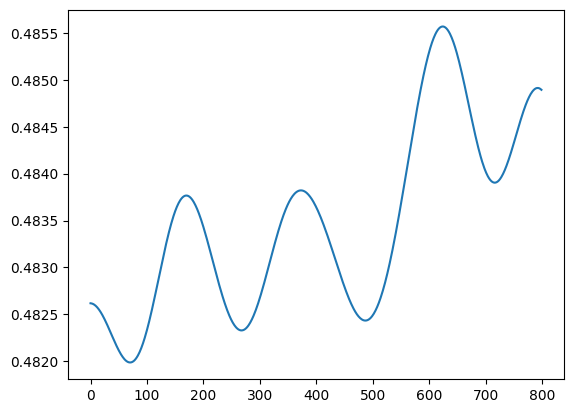

In [44]:
sns.lineplot(y[:800])

In [28]:
yvals=np.polyval(z1,x)

In [34]:
a = 1.10
b = 0.07
c = 200
d = 2
g = 176
h = 1000 / 12
y_star = a + b * np.exp(-(x - g) / c)  * np.sin((x - g) / c)

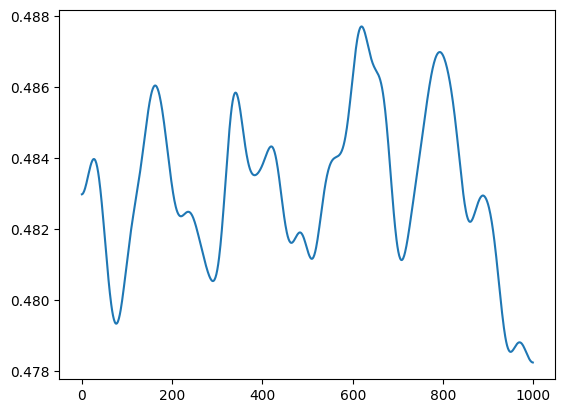

In [39]:
from matplotlib import pyplot as plt
plot1 = plt.plot(x,y,label='original values')


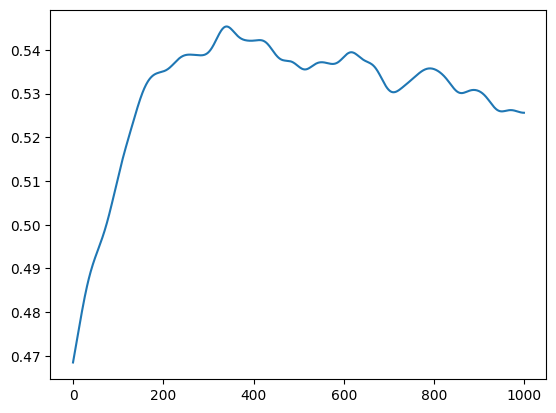

In [36]:
plt.plot(x,y*y_star)